### Neural Net with TensorFlow

In [ ]:
# Install tensorflow and protobuf -- run once!
# anaconda install instructions: https://www.tensorflow.org/install/install_mac

# # For chase's macbook, the following shell commands worked (take out ! if in terminal)
# !conda create -n tensorflow python=2.7
# !source activate tensorflow
# !pip install --ignore-installed --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.4.0-py2-none-any.whl

# Remember to activate container when you want to use package

In [47]:
import sys, csv, json
import requests
import numpy as np
import pandas as pd
import csv, json
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

In [48]:
# Import Dataset Pickle
import pickle
import pandas as pd
dfNN_raw = pickle.load(open('NN_pickles.p', 'rb'))
print dfNN_raw.head(5)
# pd.options.display.max_rows = len(dfNN_raw)
# dfNN_raw.head(len(dfNN_raw))


  prev_price compound    neg    neu   pos next_price
0     307.15   0.7424      0   0.69  0.31     307.26
1        463  -0.7003  0.209  0.791     0     467.29
2     465.01  -0.1759  0.253  0.747     0     461.57
3     464.53        0      0      1     0     465.01
4        462        0      0      1     0        465


In [49]:
# Python
# import tensorflow as tf
# hello = tf.constant('Hello, TensorFlow!')
# sess = tf.Session()
# print(sess.run(hello))

In [50]:
dfNN = (dfNN_raw - dfNN_raw.mean()) / (dfNN_raw.max() - dfNN_raw.min())
dfNN.reset_index(inplace=True)
del dfNN['index']
dfNN.head(5)
print dfNN.head(5), type(dfNN)

  prev_price   compound       neg       neu       pos next_price
0  -0.205992   0.342107 -0.041533 -0.237517   0.30568  -0.205298
1   0.468625   -0.46241  0.214909  -0.11359 -0.110987   0.487412
2   0.477325   -0.16998  0.268896 -0.167578 -0.110987   0.462653
3   0.475247 -0.0718898 -0.041533  0.142851 -0.110987   0.477543
4   0.464296 -0.0718898 -0.041533  0.142851 -0.110987     0.4775 <class 'pandas.core.frame.DataFrame'>


In [51]:
dfNN = pd.DataFrame(dfNN)
dfNN = dfNN.dropna()

In [52]:
# Taking straight from LSTM Stock Model
num_epochs = 1000

batch_size = 1

total_series_length = len(dfNN.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 6432
The current configuration gives us 2144 batches of 1 observations each one looking 3 steps in the past


In [53]:
# Split Training-Test
dfTrain = dfNN[dfNN.index < num_batches*batch_size*truncated_backprop_length]
print dfTrain

for i in range(min_test_size,len(dfNN.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(dfNN.index)-i
        break

dfTest =  dfNN[dfNN.index >= test_first_idx]

     prev_price    compound        neg         neu          pos next_price
0     -0.205992    0.342107  -0.041533   -0.237517      0.30568  -0.205298
1      0.468625    -0.46241   0.214909    -0.11359    -0.110987   0.487412
2      0.477325    -0.16998   0.268896   -0.167578    -0.110987   0.462653
3      0.475247  -0.0718898  -0.041533    0.142851    -0.110987   0.477543
4      0.464296  -0.0718898  -0.041533    0.142851    -0.110987     0.4775
5      0.477325  -0.0146195  -0.041533    -0.17494     0.237131   0.462653
6      0.472953  -0.0146195   0.203866   -0.368805      0.18068   0.455857
7      0.462435  -0.0718898  -0.041533    0.142851    -0.110987   0.451701
8      0.472953  -0.0718898  -0.041533    0.142851    -0.110987   0.455857
9      0.472953    0.212845  -0.041533   0.0115631    0.0328301   0.455857
10     0.457197  -0.0718898  -0.041533    0.142851    -0.110987    0.46209
11     0.457197  -0.0718898  -0.041533    0.142851    -0.110987    0.46209
12     0.531216    0.1522

In [54]:
xTrain = dfTrain[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain = dfTrain['next_price'].as_matrix()[::-1]

print xTrain
print yTrain
# xTrain = dfTrain[['prev_price','neu','neg','pos']]
# yTrain = dfTrain['next_price']

[[-0.24399776827917891 -0.0939583371059405 0.10693326826980906
  -0.014212921433712958]
 [-0.24399776827917891 0.14285147884497984 -0.04153298939890261
  -0.11098711498210005]
 [-0.21741998280605976 0.0845692702560228 -0.01883360289583513
  -0.07133657734769144]
 ..., 
 [0.47732506091309879 -0.1675779690077809 0.2688964584538582
  -0.11098711498210005]
 [0.46862451550577483 -0.11359023894643118 0.21490872839250844
  -0.11098711498210005]
 [-0.20599240077852973 -0.23751661931452944 -0.04153298939890261
  0.3056795516845666]]
[-0.245338122498907 -0.245338122498907 -0.24377981585878922 ...,
 0.46265252766125237 0.487412288720901 -0.20529829910699288]


In [55]:
xTrain.shape


(6427, 4)

In [56]:
xTest = dfTest[['prev_price','neu','neg','pos']].as_matrix()
yTest = dfTest['next_price'].as_matrix()

In [57]:
yTest.shape


(107,)

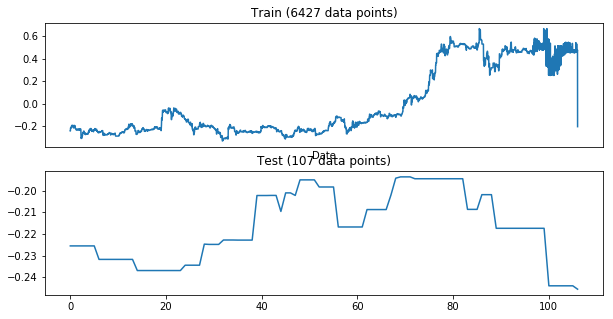

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(2,1, figsize = (10,5))
ax[0].plot(xTrain[:,0])
ax[0].set_title('Train (' +str(len(xTrain))+' data points)')
ax[0].set_xlabel('Date')
ax[0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

ax[1].plot(xTest[:,0])
ax[1].set_title('Test (' +str(len(xTest))+' data points)')

# plt.figure(figsize=(25,5))
# plt.plot(xTrain[:,0])
# plt.title('Train (' +str(len(xTrain))+' data points)')
# plt.xaxis.set_major_locator(mdates.MonthLocator())
# plt.xaxis.set_major_formatter(mdates.DateFormatter('%m.%d.%y'))

plt.show()

# plt.figure(figsize=(10,3))
# plt.plot(xTest[:,0])
# plt.title('Test (' +str(len(xTest))+' data points)')
# plt.show()

In [59]:
# LOAD DATA^

In [60]:
# SETUP NET

In [61]:
tf.reset_default_graph()


In [62]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

In [63]:
# irrelevant if no more classes (random array unif distribution) 
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

In [64]:
# unpack and create edge from input to hidden layer
labels_series = tf.unstack(batchY_placeholder, axis=1)


In [65]:
# forward pass
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [66]:
# talk about permutations and how data goes through nodes
states_series = tf.transpose(states_series,[1,0,2])


In [67]:
# backwards pass starting point
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

In [68]:
# bp weights and biases
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [69]:
prediction = tf.matmul(last_state,weight) + bias
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


In [70]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 50
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            try:
                batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
                batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
            except:
                print xTrain, start_idx, end_idx, batch_size, truncated_backprop_length, num_features
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one
        

Epoch 0
Step 0 - Loss: 0.076313
Step 50 - Loss: 0.000248
Step 100 - Loss: 0.000053
Step 150 - Loss: 0.000078
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000044
Step 350 - Loss: 0.000002
Step 400 - Loss: 0.000004
Step 450 - Loss: 0.000092
Step 500 - Loss: 0.004938
Step 550 - Loss: 0.001540
Step 600 - Loss: 0.000002
Step 650 - Loss: 0.000183
Step 700 - Loss: 0.000012
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000081
Step 900 - Loss: 0.000039
Step 950 - Loss: 0.000905
Step 1000 - Loss: 0.000024
Step 1050 - Loss: 0.000026
Step 1100 - Loss: 0.000466
Step 1150 - Loss: 0.000044
Step 1200 - Loss: 0.000492
Step 1250 - Loss: 0.000006
Step 1300 - Loss: 0.000003
Step 1350 - Loss: 0.000453
Step 1400 - Loss: 0.000002
Step 1450 - Loss: 0.000299
Step 1500 - Loss: 0.000592
Step 1550 - Loss: 0.004701
Step 1600 - Loss: 0.001776
Step 1650 - Loss: 0.000077
Step 1700 - Loss: 0.000206
Step 1750 - Loss: 0.003067
Step 1800 - Loss: 0.001073
Step 1850 - Loss

KeyboardInterrupt: 

## WOOO!

In [ ]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)), y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

### Now we split the data into disjoint time intervals

In [86]:
dfNN_sorted = pickle.load(open('NN_pickled_time.p', 'rb'))
dfNN_sorted = dfNN_sorted.sort_values('datetime')
dfNN_mean = dfNN_sorted.mean()
dfNN_max = dfNN_sorted.max()
dfNN_min = dfNN_sorted.min()
dfNN_sorted = (dfNN_sorted - dfNN_mean) / (dfNN_max - dfNN_min)
dfNN_sorted.reset_index(inplace=True)
del dfNN_sorted['index']
dfNN_sorted.head(5)
print dfNN_sorted.head(5), type(dfNN)


  prev_price    compound        neg        neu        pos next_price  datetime
0  -0.245556  0.00428477  -0.041533  0.0894772 -0.0525194  -0.241053 -0.566531
1  -0.243998  -0.0718898  -0.041533   0.142851  -0.110987  -0.245338  -0.56593
2  -0.243998  -0.0975415   0.106933 -0.0939583 -0.0142129  -0.245338  -0.56593
3  -0.243998   -0.134988  0.0652155 -0.0350626 -0.0330301  -0.245338  -0.56593
4  -0.243998    -0.16669  0.0382216  0.0630969  -0.110987  -0.245338  -0.56593 <class 'pandas.core.frame.DataFrame'>


In [87]:
dfNN_sorted = pd.DataFrame(dfNN_sorted)
dfNN_sorted = dfNN_sorted.dropna()

In [88]:
Train2 = dfNN_sorted.iloc[:6300, :]
Test2 = dfNN_sorted.iloc[6300:, :]
# Test2 = pd.DataFrame(Test2, columns = ['prev_price', 'compound', 'neg', 'neu','pos','next_price'])

print len(dfNN), len(Train2), dfNN.head(3), Test2.head(4)

xTrain2 = Train2[['prev_price','neu','neg','pos']].as_matrix()[::-1]
yTrain2 = Train2['next_price'].as_matrix()[::-1]


xTest2 = Test2[['prev_price','neu','neg','pos']].as_matrix()
yTest2 = Test2['next_price'].as_matrix()

6432 6300   prev_price  compound       neg       neu       pos next_price
0  -0.205992  0.342107 -0.041533 -0.237517   0.30568  -0.205298
1   0.468625  -0.46241  0.214909  -0.11359 -0.110987   0.487412
2   0.477325  -0.16998  0.268896 -0.167578 -0.110987   0.462653      prev_price   compound       neg        neu        pos next_price  \
6300   0.473516    0.33338 -0.041533 -0.0945718   0.149094   0.457501   
6301   0.473516   0.117933 -0.041533  -0.129541     0.1874   0.457501   
6302   0.479792  0.0560344 -0.041533  0.0815018 -0.0437828   0.473734   
6303   0.479792   0.128166 -0.041533  0.0661644 -0.0269817   0.473734   

      datetime  
6300  0.417243  
6301  0.417243  
6302  0.417844  
6303  0.417844  


In [89]:
tf.reset_default_graph()

batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

# irrelevant if no more classes (random array unif distribution) 
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

# unpack and create edge from input to hidden layer
labels_series = tf.unstack(batchY_placeholder, axis=1)

# forward pass
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)
states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

# talk about permutations and how data goes through nodes
states_series = tf.transpose(states_series,[1,0,2])

# backwards pass starting point
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

# bp weights and biases
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

prediction = tf.matmul(last_state,weight) + bias
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))
train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


In [94]:
loss_list2 = []
test_pred_list2 = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    num_epochs = 10
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            try:
                batchX = xTrain2[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
                batchY = yTrain2[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
            except:
                pass
#                 print xTrain2, start_idx, end_idx, batch_size, truncated_backprop_length, num_features
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list2.append(_loss)
            
#             if type(loss) != float(1):
#                 print _loss,_train_step,_pred,_last_label,_prediction
            
           
            
            #if(batch_idx % 50 == 0):
              #  print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest2) - truncated_backprop_length):
        
        try:
            testBatchX = xTest2[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
            testBatchY = yTest2[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))
        except:
            pass
        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list2.append(test_pred[-1][0]) #The last one
        

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [96]:
avgloss = sum(loss_list2)/float(len(loss_list2))
print avgloss

0.000778011958752


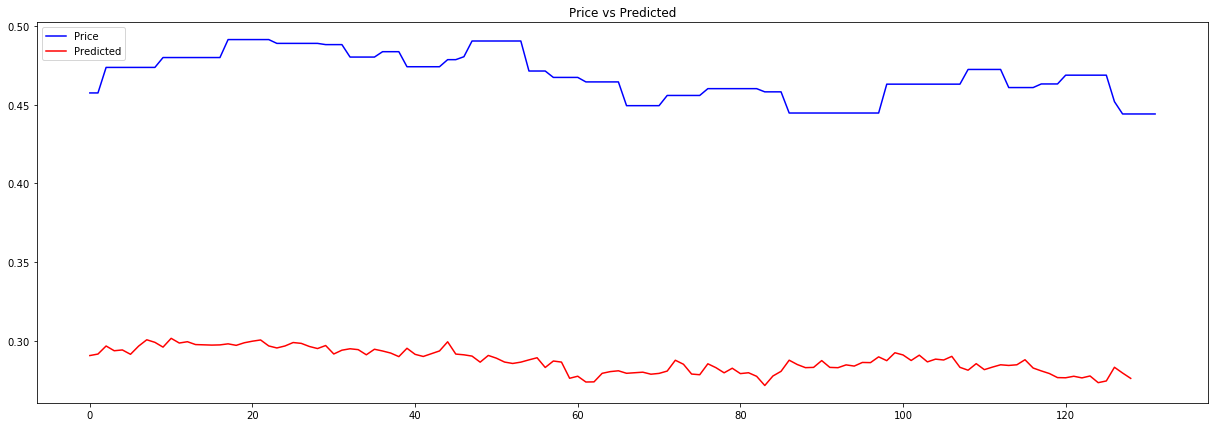

In [95]:
def unnorm(list):
    new_list = []
    for item in list:
#         print type(item)
        new_item = (float(item) + dfNN_mean) * (dfNN_max - dfNN_min)
        new_list.append(new_item)
    return new_item

unnorm_yTest2 = list(unnorm(yTest2))
unnorm_test_pred_list2 = list(unnorm(test_pred_list2))

#print type(unnorm_yTest2), 'datetime' in unnorm_yTest2, unnorm_yTest2

# print yTest2, test_pred_list2

plt.figure(figsize=(21,7))
plt.plot(yTest2,label='Price',color='blue')
plt.plot(test_pred_list2,label='Predicted',color='red')
# plt.plot(unnorm_yTest2,label='Price',color='blue')
# plt.plot(unnorm_test_pred_list2,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list2)), y=loss_list)
plt.xlabel('X')
plt.ylabel('loss')
plt.show()